# Survival Analysis of Endometrial Cancer: Tumor Pathological Stage

Through modern statistical methods, we can determine survival risk based on a variety of factors.  In this tutorial, we will walk through a small example of something you could do with our data to understand what factors relate with survival in various different types of cancer.  In this use case, we will be looking at Endometrial Cancer

## Step 1: Import Data and Dependencies

In [1]:
import pandas as pd
import cptac
import numpy as np
import sksurv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
en = cptac.Endometrial()
clinical = en.get_clinical()
proteomics = en.get_proteomics()

In [3]:
follow_up = pd.read_excel('../Follow_Up_Data/UCEC_followup_9_12.xlsx')

## Step 2: Data Preparation
We will be focusing on the discovery cohort of tumors, for which we have follow-up data. We will perform some data cleaning, and then merge the tables together for analysis. While you could study a wide variety of factors related to survival, such as country of origin or number of full pregnancies, we will be focusing on tumor stage and grade.

In [5]:
#Replace redundant values for not reported with NaN       
to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown',
              'Not Applicable', 'na', 'unknown', 'Not Performed',
              'Unknown tumor status', 'Unknown',
              'Unknown Tumor Status', 'Not specified']

follow_up = follow_up.replace(to_replace, np.nan)

#Rename column to merge on, and then merge follow-up with clinical data
follow_up = follow_up.rename({'Case ID': 'Patient_ID'}, axis='columns')
patient_data = pd.merge(clinical, follow_up, on = 'Patient_ID')

#Determine columns to focus on, and create a subset to work with
columns_to_focus_on = ['Patient_ID', 'Vital Status', 
                       'Histologic_Grade_FIGO', 
                       'Path Diag to Last Contact(Day)', 
                       'Path Diag to Death(days)', 
                       'Histologic_type',
                       'tumor_Stage-Pathological',
                       'Path Diag to new Tumor (days)', 
                       'New Tumor After Initial TRT']

focus_group = patient_data[columns_to_focus_on].copy().drop_duplicates()

## Step 2b: Prepare data for Kaplan Meier Plotting
We will start by finding all patients that have negative outcomes, which we have defined as either death, or developing a new tumor after initial treatment. Then, we will create a column for this data that we named "Negative_Outcome" below. This column contains boolean values, where True denotes that the event occurred, and False denotes that it did not.

In [7]:
new_tumor = focus_group["New Tumor After Initial TRT"] == "Yes"
deceased = focus_group["Vital Status"] == "Deceased"

new_tumor_patients = focus_group.Patient_ID[new_tumor]
deceased_patients = focus_group.Patient_ID[deceased]

neg_outcomes = new_tumor_patients.append(deceased_patients).drop_duplicates()

#Create a boolean column for these patients for use in Survival Analysis
focus_group['Negative_Outcome'] = neg_outcomes
focus_group['Negative_Outcome'] = focus_group['Negative_Outcome'].replace(neg_outcomes.values, True)
focus_group['Negative_Outcome'] = focus_group['Negative_Outcome'].replace(np.nan, False)

#There is one erroneous negative value in this column, so we will remove it from our subset
focus_group = focus_group[focus_group['Path Diag to new Tumor (days)'] != -1562.0]

Next, we will create a column for the number of days it took for that negative outcome to occur.  We have named that column "Timeframe" below.

In [8]:
temp_neg_outcomes = focus_group[focus_group["Negative_Outcome"] == True].copy()
new_tumor_times = temp_neg_outcomes['Path Diag to new Tumor (days)'][temp_neg_outcomes["New Tumor After Initial TRT"] == "Yes"]
death_times = temp_neg_outcomes['Path Diag to Death(days)'][temp_neg_outcomes["Vital Status"] == "Deceased"]

#Get rid of duplicates that may have different time frames 
#between the new tumor and deceased subsets
for i in death_times.index:
    if i in new_tumor_times.index:
        death_times = death_times.drop([i])

focus_group['Timeframe'] = new_tumor_times.append(death_times).drop_duplicates()
focus_group['Timeframe'] = focus_group['Timeframe'].replace(np.nan, focus_group['Path Diag to Last Contact(Day)'])

focus_group = focus_group[["Histologic_Grade_FIGO", "tumor_Stage-Pathological", 
                           "Negative_Outcome", "Timeframe"]].dropna().copy()

For Kaplan Meier plots, your data needs to be in the format shown below.  Specifically, it needs a boolean column for the 'event' you are interested in ("Negative_Outcome"),  and a column with a numeric time frame ("Timeframe").  The other columns contain categorical data that we are testing to find meaningful connections with positive or negative event outcomes.

In [9]:
focus_group.head()

,Histologic_Grade_FIGO,tumor_Stage-Pathological,Negative_Outcome,Timeframe
0,FIGO grade 1,Stage I,False,494.0
1,FIGO grade 1,Stage I,False,717.0
2,FIGO grade 1,Stage I,False,737.0
6,FIGO grade 1,Stage IV,False,440.0
7,FIGO grade 1,Stage IV,False,624.0


# Step 3: Kaplan-Meier Plots
Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute(s).  Oftentimes, they are used to plot the probability of death for clinical attributes, however they could also be used in a variety of other contexts.  Below are a few examples of Kaplan Meier Plots in regards to Histologic Grade, and Tumor Stage of patients with Endometrial Cancer:

Here, we show a general Kaplan Meier Plot of survival overall for our cohort, using the KaplanMeierFitter() from the lifelines package.

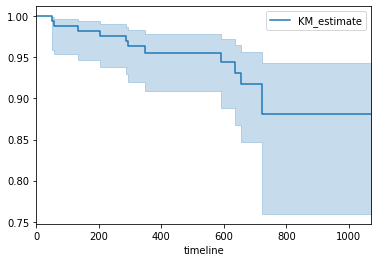

In [10]:
time = focus_group['Timeframe']
status = focus_group['Negative_Outcome']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4: Format data for Cox's Proportional Hazard test
We will now convert the data into numeric values for the attributes we are interested in exploring.  This is necessary to fit the CoxPHFitter() to our data, to create covariate Kaplan Meier plots, and to perform proportional hazard tests.

In [11]:
figo_map = {"FIGO grade 1": 1, "FIGO grade 2": 2, "FIGO grade 3" : 3}
focus_group['Histologic_Grade_FIGO'] = focus_group['Histologic_Grade_FIGO'].map(figo_map)

tumor_map = {"Stage I" : 1, "Stage II" : 2, "Stage III" : 3, "Stage IV" : 4}
focus_group['tumor_Stage-Pathological'] = focus_group['tumor_Stage-Pathological'].map(tumor_map)

With the CoxPHFitter from the lifelines package we can see more in-depth survival plots based on multiple variables, as shown below.  Namely, Tumor Histologic Grade and Tumor Stage.

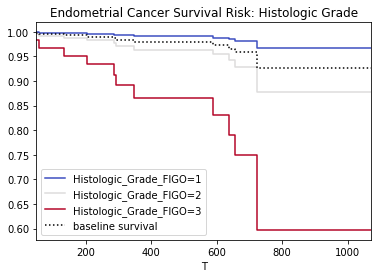

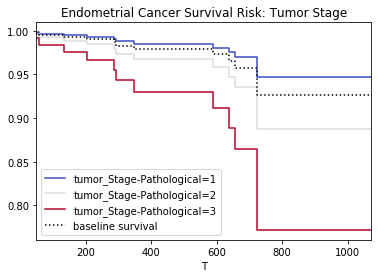

In [12]:
cph = CoxPHFitter()
cph.fit(focus_group, duration_col = "Timeframe", event_col = "Negative_Outcome")
cph.plot_covariate_groups('Histologic_Grade_FIGO', [1,2,3], cmap='coolwarm', 
                          title= "Endometrial Cancer Survival Risk: Histologic Grade")
cph.plot_covariate_groups('tumor_Stage-Pathological', [1,2,3], cmap='coolwarm', 
                          title= "Endometrial Cancer Survival Risk: Tumor Stage")

# REWORD ME
These plots appear to have very similar functions across the variables, however, Histologic_Grade_FIGO=3 tends to have more negative outcomes than tumor_Stage-Pathological=3. And, as shown below, with our Survival Regression analysis, Histologic Grade has a lower p-value than Tumor Stage, which is not surprising, since more negative outcomes occurred for patients with Histologic Grade 3 tumors.

In [13]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 172 total observations, 161 right-censored observations>
      duration col = 'Timeframe'
         event col = 'Negative_Outcome'
number of observations = 172.0
number of events observed = 11.0
partial log-likelihood = -42.514
  time fit was run = 2020-01-03 23:02:43 UTC
             model = untransformed variables


---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Histologic_Grade_FIGO    1.369     3.931     0.443           0.501           2.236               1.651               9.357
tumor_Stage-Pathological 0.776     2.173     0.296           0.196           1.356               1.217               3.880

                             z     p  -log2(p)
Histologic_Grade_FIGO    3.093 0.002     8.980
tumor_Stage-Pathological 2.624 0.009     6.845
---
Concordance = 0.813
Log-likelihood ratio test = 17.976 on 2 df, -log2(p)=12.967


We then can perform a Cox Proportional Hazard test, using the *lifelines* package, to determine how much more or less risk a patient would have for the event of interest to occur based on the variables that we are looking at. It also produces a p-value to determine if these variables explain a statistically significant amount of the negative outcomes in our data (moreso than would be expected by random chance).

In [14]:
results = proportional_hazard_test(cph, focus_group, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
                          test_statistic     p  -log2(p)
Histologic_Grade_FIGO              0.230 0.632     0.663
tumor_Stage-Pathological           0.502 0.478     1.064


The hazard ratios for Histologic Grade and Tumor Stage are located in the column labeled "-log2(p)" above. If a ratio is greater than 1, the hazard is greater than would be expected, suggesting that the feature associated with it has a higher likelihood of the negative event occurring than would normally be expected.  Likewise, if the ratio is less than 1, the opposite is true.  A ratio of 1 would be considered normal.

Below, we show confidence intervals for each of the two hazard ratios.  Since both bars include the log(HR) of 1.0 and both of their p-values were greater than 0.05, there is insufficient evidence to suggest that a specific Histologic Grade or Tumor Stage is connected with negative clinical outcomes of death or the development of a new tumor *in our cohort of Endometrial cancer tumors*.

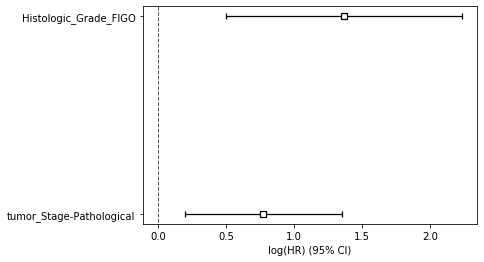

In [15]:
cph.plot()

 It is important to note that there are relatively few patients who had negative outcomes (11 out of 172), which is good, but with such a small sample size, it is difficult to conclude with certainty that these features are not more connected with negative outcomes.  Perhaps a sample of patients with more negative outcomes might have different results.  

It is also important to recognize that the confidence intervals for these ratios are very large, especially since hazard ratios are on a log-scale.

In [16]:
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
Histologic_Grade_FIGO,0.501467,2.236144
tumor_Stage-Pathological,0.196345,1.355928


This is just one example of how you might use Survival Analysis to learn more about different types of cancer, and how clinical and/or genetic attributes contribute to likelihood of survival. There are many other clinical and genetic attributes, as well as several other cancer types, that can be explored using a similar process to that above. In particular, lung cancer and ovarian cancer have a larger number of negative outcomes per cohort, and would be good to look into further. 